<a href="https://colab.research.google.com/github/Abhijit-2592/visualizing_cnns/blob/master/saliency_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In this and the activation_maximization.ipynb notebooks we will try to understand the visualization technique presented in the following paper:


[Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf).

Here we are trying to find the regions of image which are mostly responsible for a specific class prediction

## NOTE:

In the paper under section 3, the authors approximate the linear scoring function by using the 1st order term from the Tailor expansion of the softmax function (See equations 2 and 3). Instead of taking the 1st order term from the Tailor expansion we can do another trick to approximate a Linear scoring function: Just Swap the Softmax activation to a Linear/Identity activation in the output.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

553467904/553467096 [==============================] - 13s 0us/step


In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

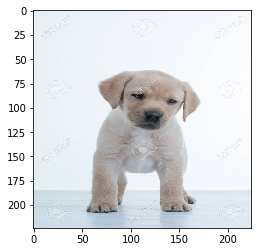

In [0]:
image = np.array(tf.keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.imshow(image)
plt.show()

In [0]:
preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image.astype(np.float32))
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # reshape it to (1,224,224,3),

In [0]:
# trick to get optimal visualizations swap softmax with linear
model.get_layer("predictions").activation = None

In [0]:
def get_gradients(model, image, class_index):
    image_tensor = tf.convert_to_tensor(image, dtype="float32")
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        output = model(image_tensor)
        loss = tf.reduce_mean(output[:, class_index])
    grads = tape.gradient(loss, image_tensor)
    return grads

In [0]:
class_index = 208  # labrador
grads = get_gradients(model, preprocessed_image, class_index=class_index)

In [0]:
gradient_image = grads.numpy()[0]

In [0]:
gradient_image.shape

(224, 224, 3)

In [0]:
saliency_map = np.max(np.abs(gradient_image), axis=2)

In [0]:
saliency_map.shape

(224, 224)

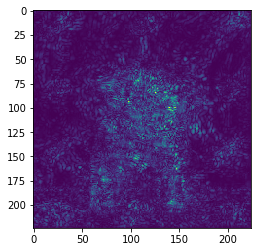

In [0]:
plt.imshow(saliency_map)
plt.show()

The visualized saliency maps are a bit noisy. We can get better saliency maps by doing guided backprop: see slide 25 from [Andrej's lecture](http://cs231n.stanford.edu/slides/2016/winter1516_lecture9.pdf)